## MLOps Zoomcamp - Homework 3

### Question 1. Run Mage

After running the following command, I could access the Mage interface.
```
git clone https://github.com/mage-ai/mlops.git
cd mlops
```

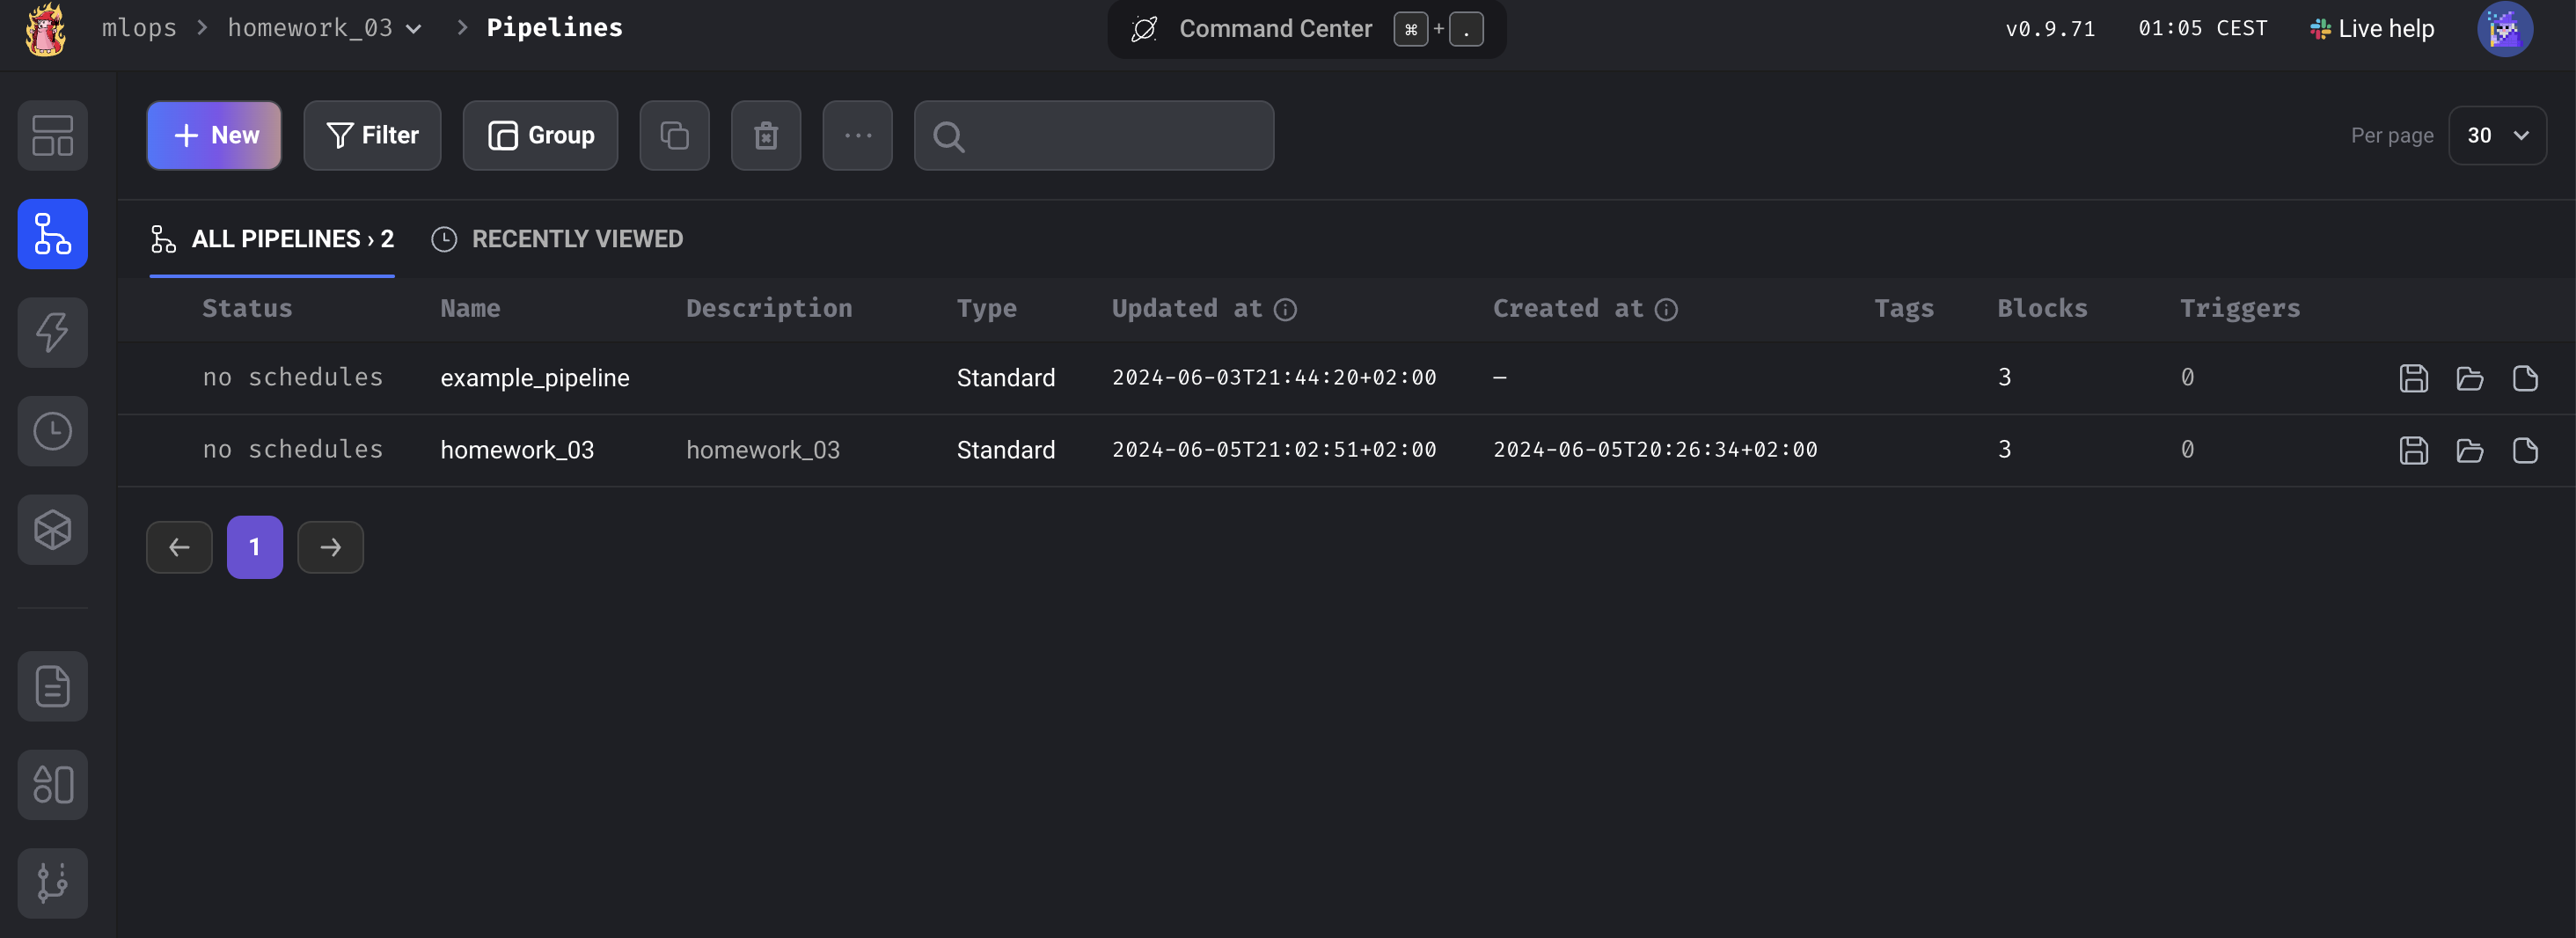

In [4]:
from IPython.display import Image
Image('img/q1.png')


In the upper right corner, I can see the Mage version which is `v0.7.71`.

### Question 2. Creating a project
I create the new project and register it in the settings. This result in the`yaml` that is 55 lines long. Below is the yaml file I obtained.

```
project_type: standalone

variables_dir: ~/.mage_data
# remote_variables_dir: s3://bucket/path_prefix

variables_retention_period: '90d'

emr_config:
  # You can customize the EMR cluster instance size with the two parameters
  master_instance_type: 'r5.4xlarge'
  slave_instance_type: 'r5.4xlarge'

  # Configure security groups for EMR cluster instances.
  # The default managed security groups are ElasticMapReduce-master and ElasticMapReduce-slave
  # master_security_group: 'sg-xxxxxxxxxxxx'
  # slave_security_group: 'sg-yyyyyyyyyyyy'

  # If you want to ssh tunnel into EMR cluster, ec2_key_name must be configured.
  # You can create a key pair in page https://console.aws.amazon.com/ec2#KeyPairs and download the key file.
  # ec2_key_name: '[ec2_key_pair_name]'

spark_config:
  # Application name
  app_name: 'my spark app'
  # Master URL to connect to
  # e.g., spark_master: 'spark://host:port', or spark_master: 'yarn'
  spark_master: 'local'
  # Executor environment variables
  # e.g., executor_env: {'PYTHONPATH': '/home/path'}
  executor_env: {}
  # Jar files to be uploaded to the cluster and added to the classpath
  # e.g., spark_jars: ['/home/path/example1.jar']
  spark_jars: []
  # Path where Spark is installed on worker nodes
  # e.g. spark_home: '/usr/lib/spark'
  spark_home:
  # List of key-value pairs to be set in SparkConf
  # e.g., others: {'spark.executor.memory': '4g', 'spark.executor.cores': '2'}
  others: {}
  # Whether to create custom SparkSession via code and set in kwargs['context']
  use_custom_session: false
  # The variable name to set in kwargs['context'],
  # e.g. kwargs['context']['spark'] = spark_session
  custom_session_var_name: 'spark'

help_improve_mage: true
notification_config:
  alert_on:
  - trigger_failure
  - trigger_passed_sla
  slack_config:
    webhook_url: "{{ env_var('MAGE_SLACK_WEBHOOK_URL') }}"
  teams_config:
    webhook_url: "{{ env_var('MAGE_TEAMS_WEBHOOK_URL') }}"
project_uuid: homework_03
```


### Question 3. Creating a pipeline

First, I downloaded the data to the local directory. I then created a data ingestion block with the simple code. The code snippet is below.

In [ ]:
@data_loader


def load_data(*args, **kwargs):
    # define the path to the Parquet file
    parquet_file_path = '/home/src/mlops/homework_03/data/yellow_tripdata_2023-03.parquet'

   # read the file
    df = pd.read_parquet(parquet_file_path)

    # return the dataframe
    return df



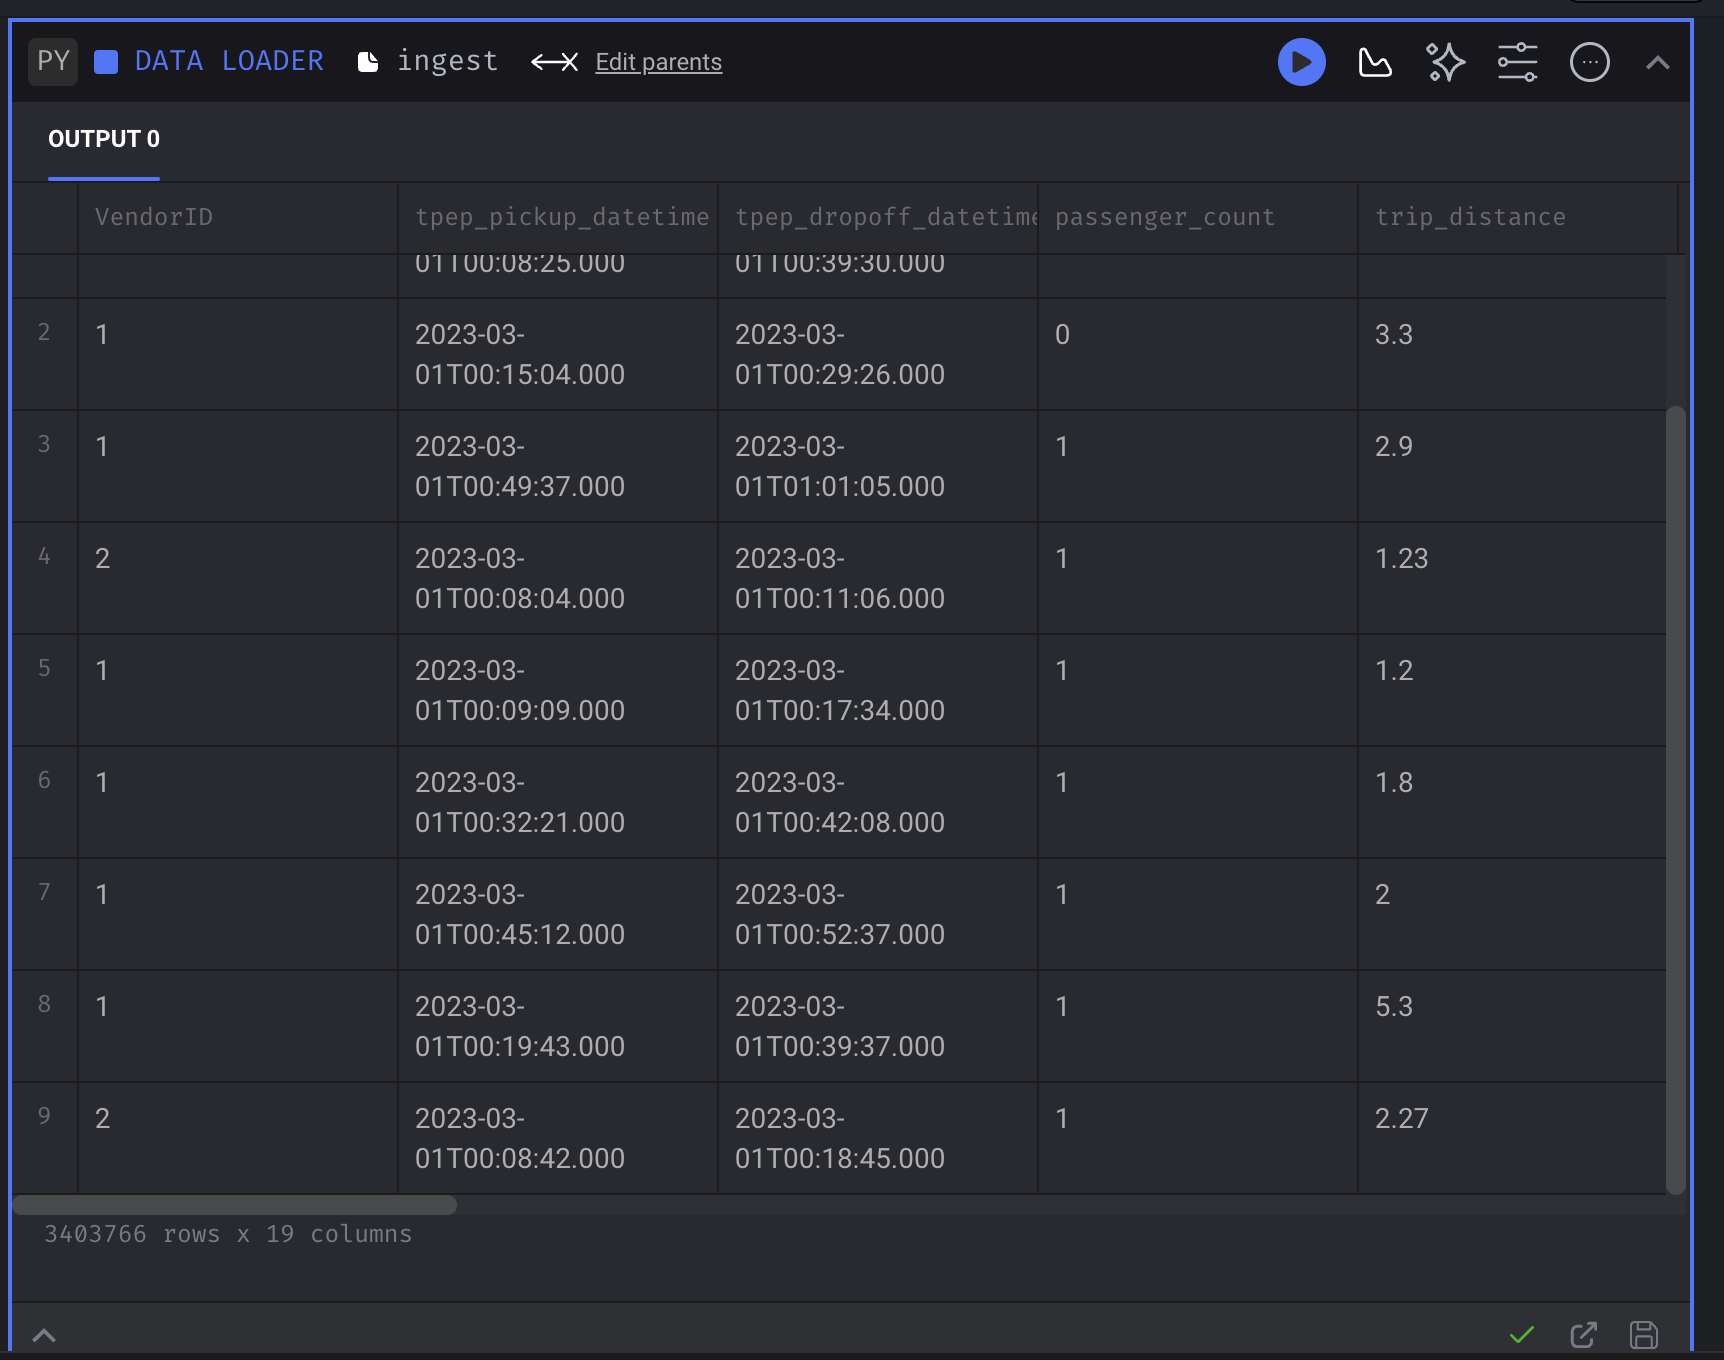

In [2]:
Image('img/q3.png')

The dataframe has `3403766` rows.

### Question 4. Data preparation

I created new transformer block and adapted the provided code for the data preparation. Below is the adapted code snippet.

In [ ]:
@transformer
def transform(df, *args, **kwargs):
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

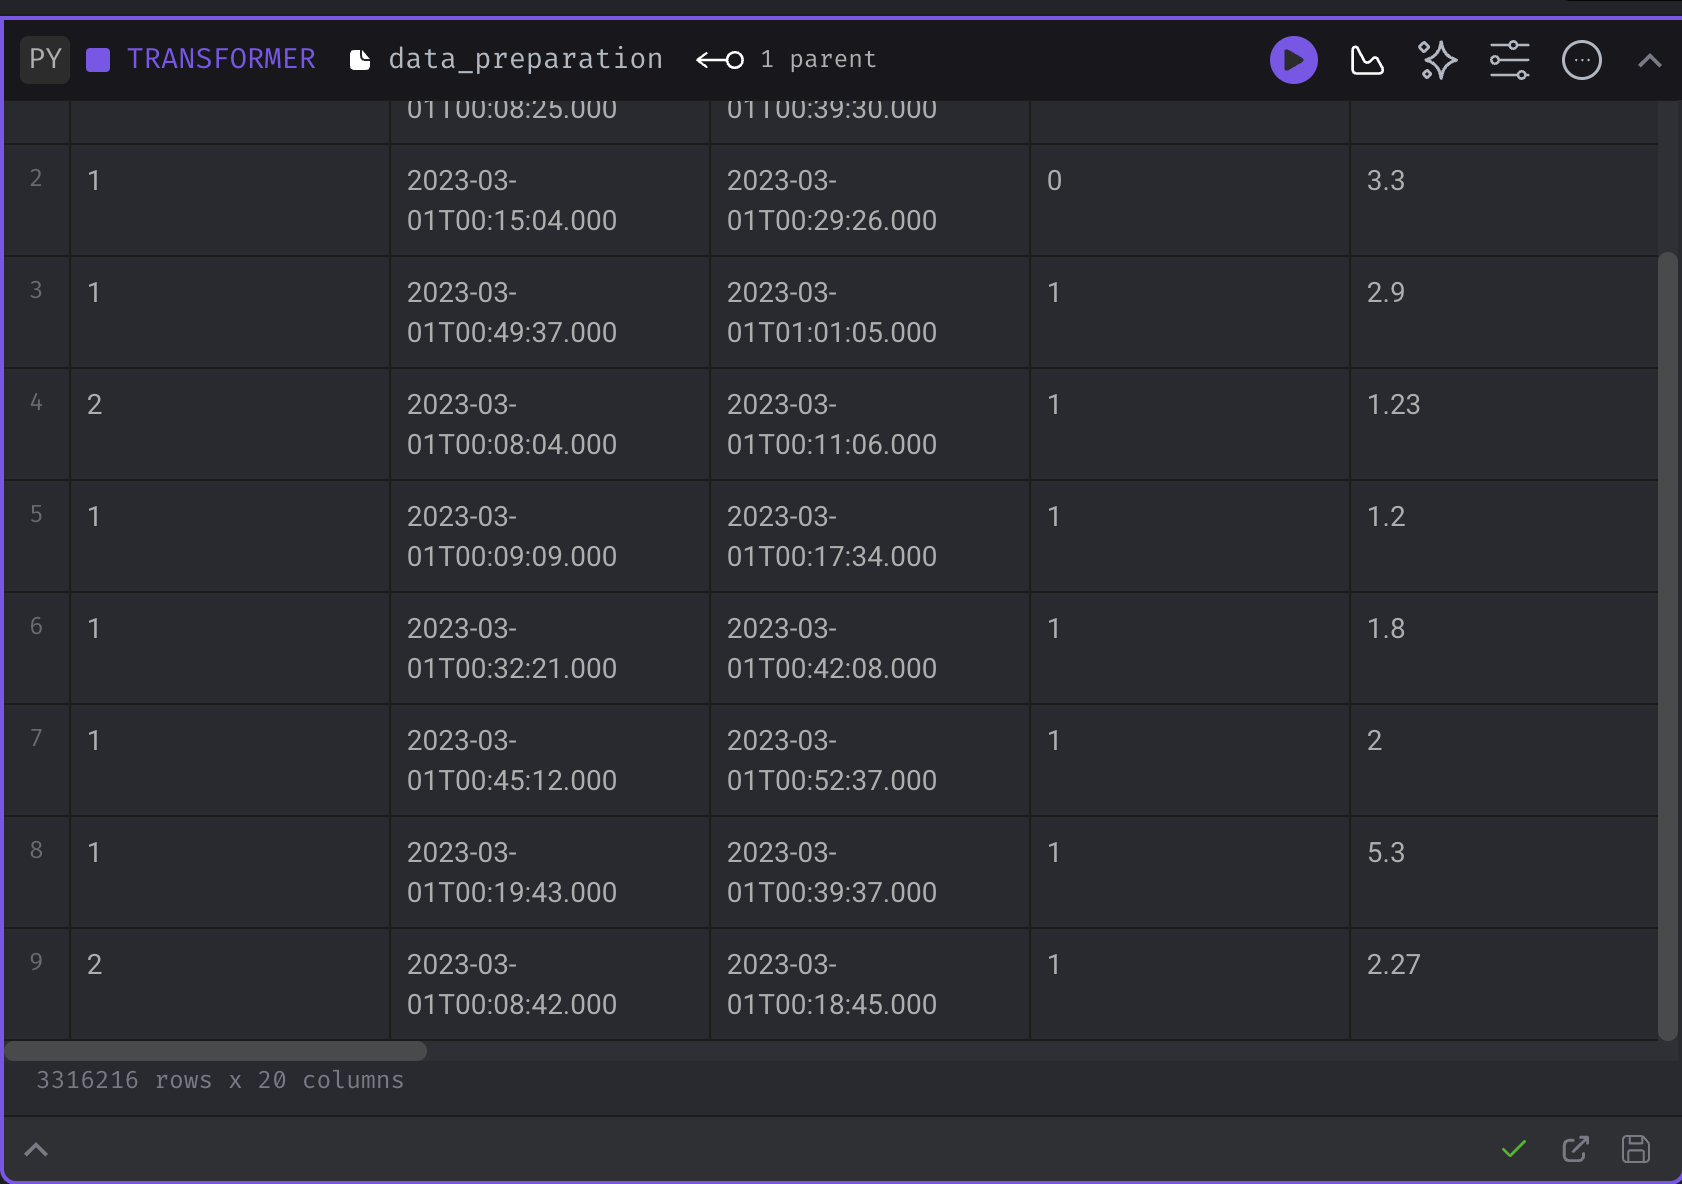

In [3]:
Image('img/q4.png')

The modified dataframe has `3316216` rows.

### Question 5 & Question 6.  Train and register the model

Below is the training and registering code snippet. Full version can be found in the directory under `hw_3/mlops/homework_03`.

In [ ]:
@transformer
def transform(df, *args, **kwargs):
    # Ensure the relevant columns are in string format
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    # Create a dictionary representation of the DataFrame
    train_dicts = df[categorical].to_dict(orient='records')
    
    # Fit the DictVectorizer
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dicts)
    print(f'Feature matrix size: {X_train.shape}')
    
    # Train the Linear Regression model
    target = 'duration'
    y_train = df[target].values
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # Predict and calculate RMSE
    y_pred = lr.predict(X_train)
    print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')
    
    # Print the intercept
    print(f'Model intercept: {lr.intercept_}')
    
    # Set the MLflow tracking URI (adjust if necessary)
    mlflow.set_tracking_uri('http://mlflow:5000')
    
    # Start an MLflow run
    with mlflow.start_run() as run:
        # Log the linear regression model
        mlflow.sklearn.log_model(lr, "linear_regression_model")
        
        # Save and log the DictVectorizer as an artifact
        with open("dict_vectorizer.pkl", "wb") as f:
            pickle.dump(dv, f)
        mlflow.log_artifact("dict_vectorizer.pkl")
    
    print(f"Model and DictVectorizer logged to MLflow with run_id: {run.info.run_id}")
    
    # Return the vectorizer and the model
    return {
        'dict_vectorizer': dv,
        'linear_regression_model': lr
    }

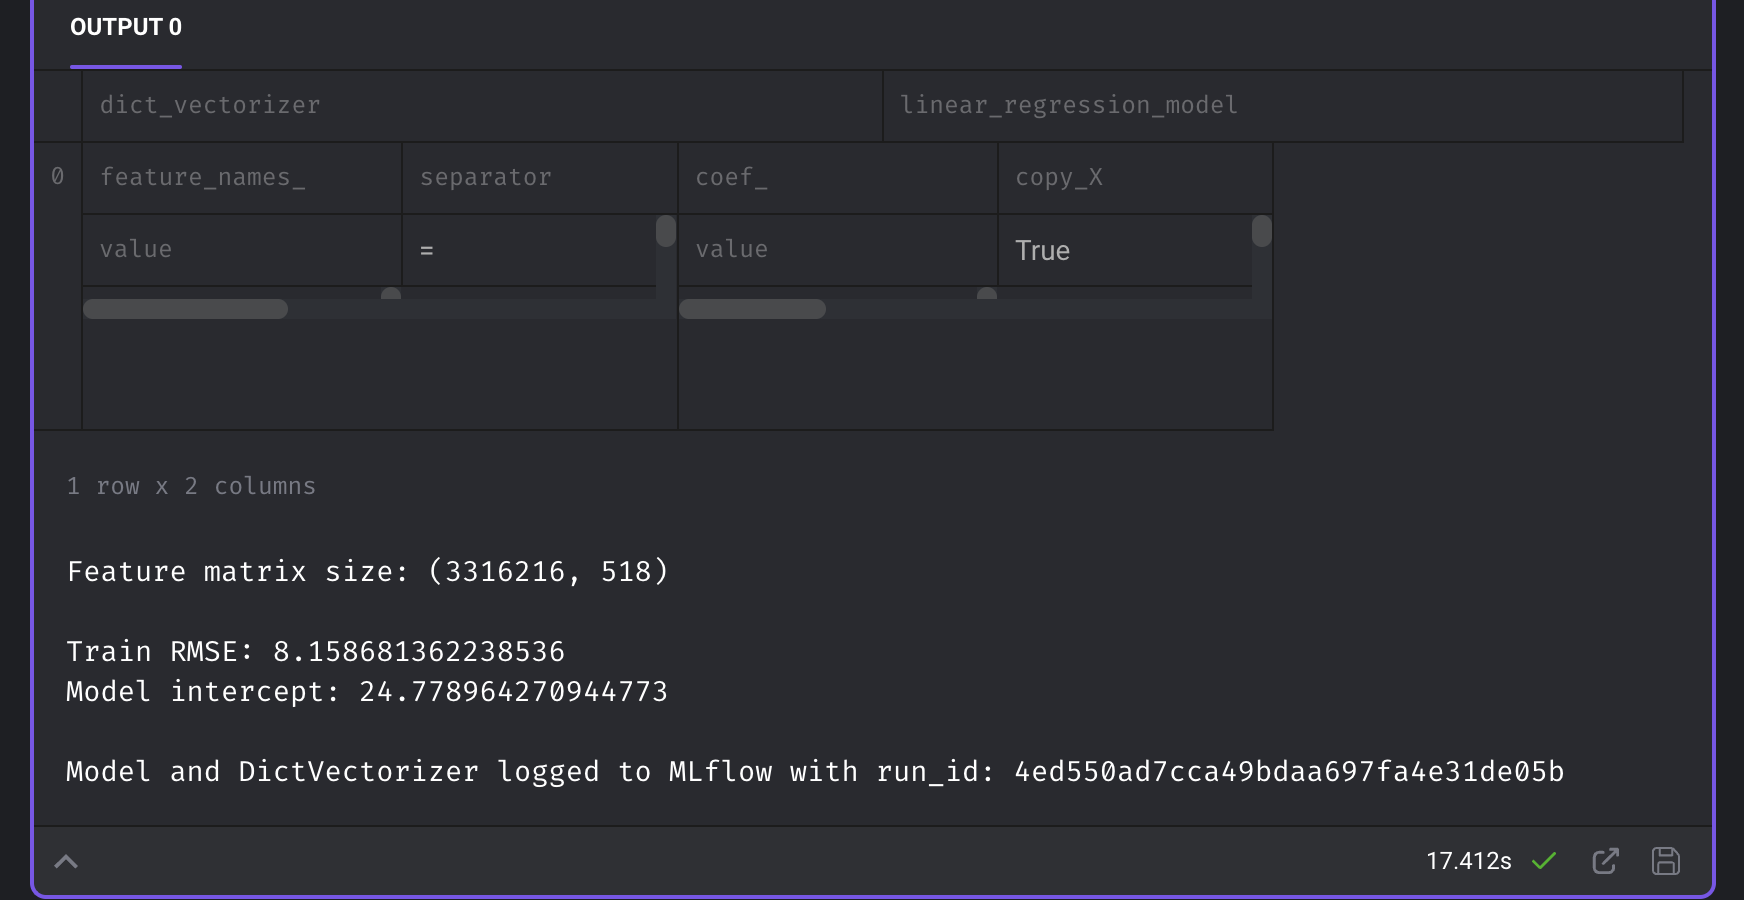

In [5]:
Image('img/q5.png')

The intercept is then `24.779`. Model was logged to MlFlow. When accessing MLFlow, we can see that the size of the model is `4500` bytes. Screenshot is provided below.


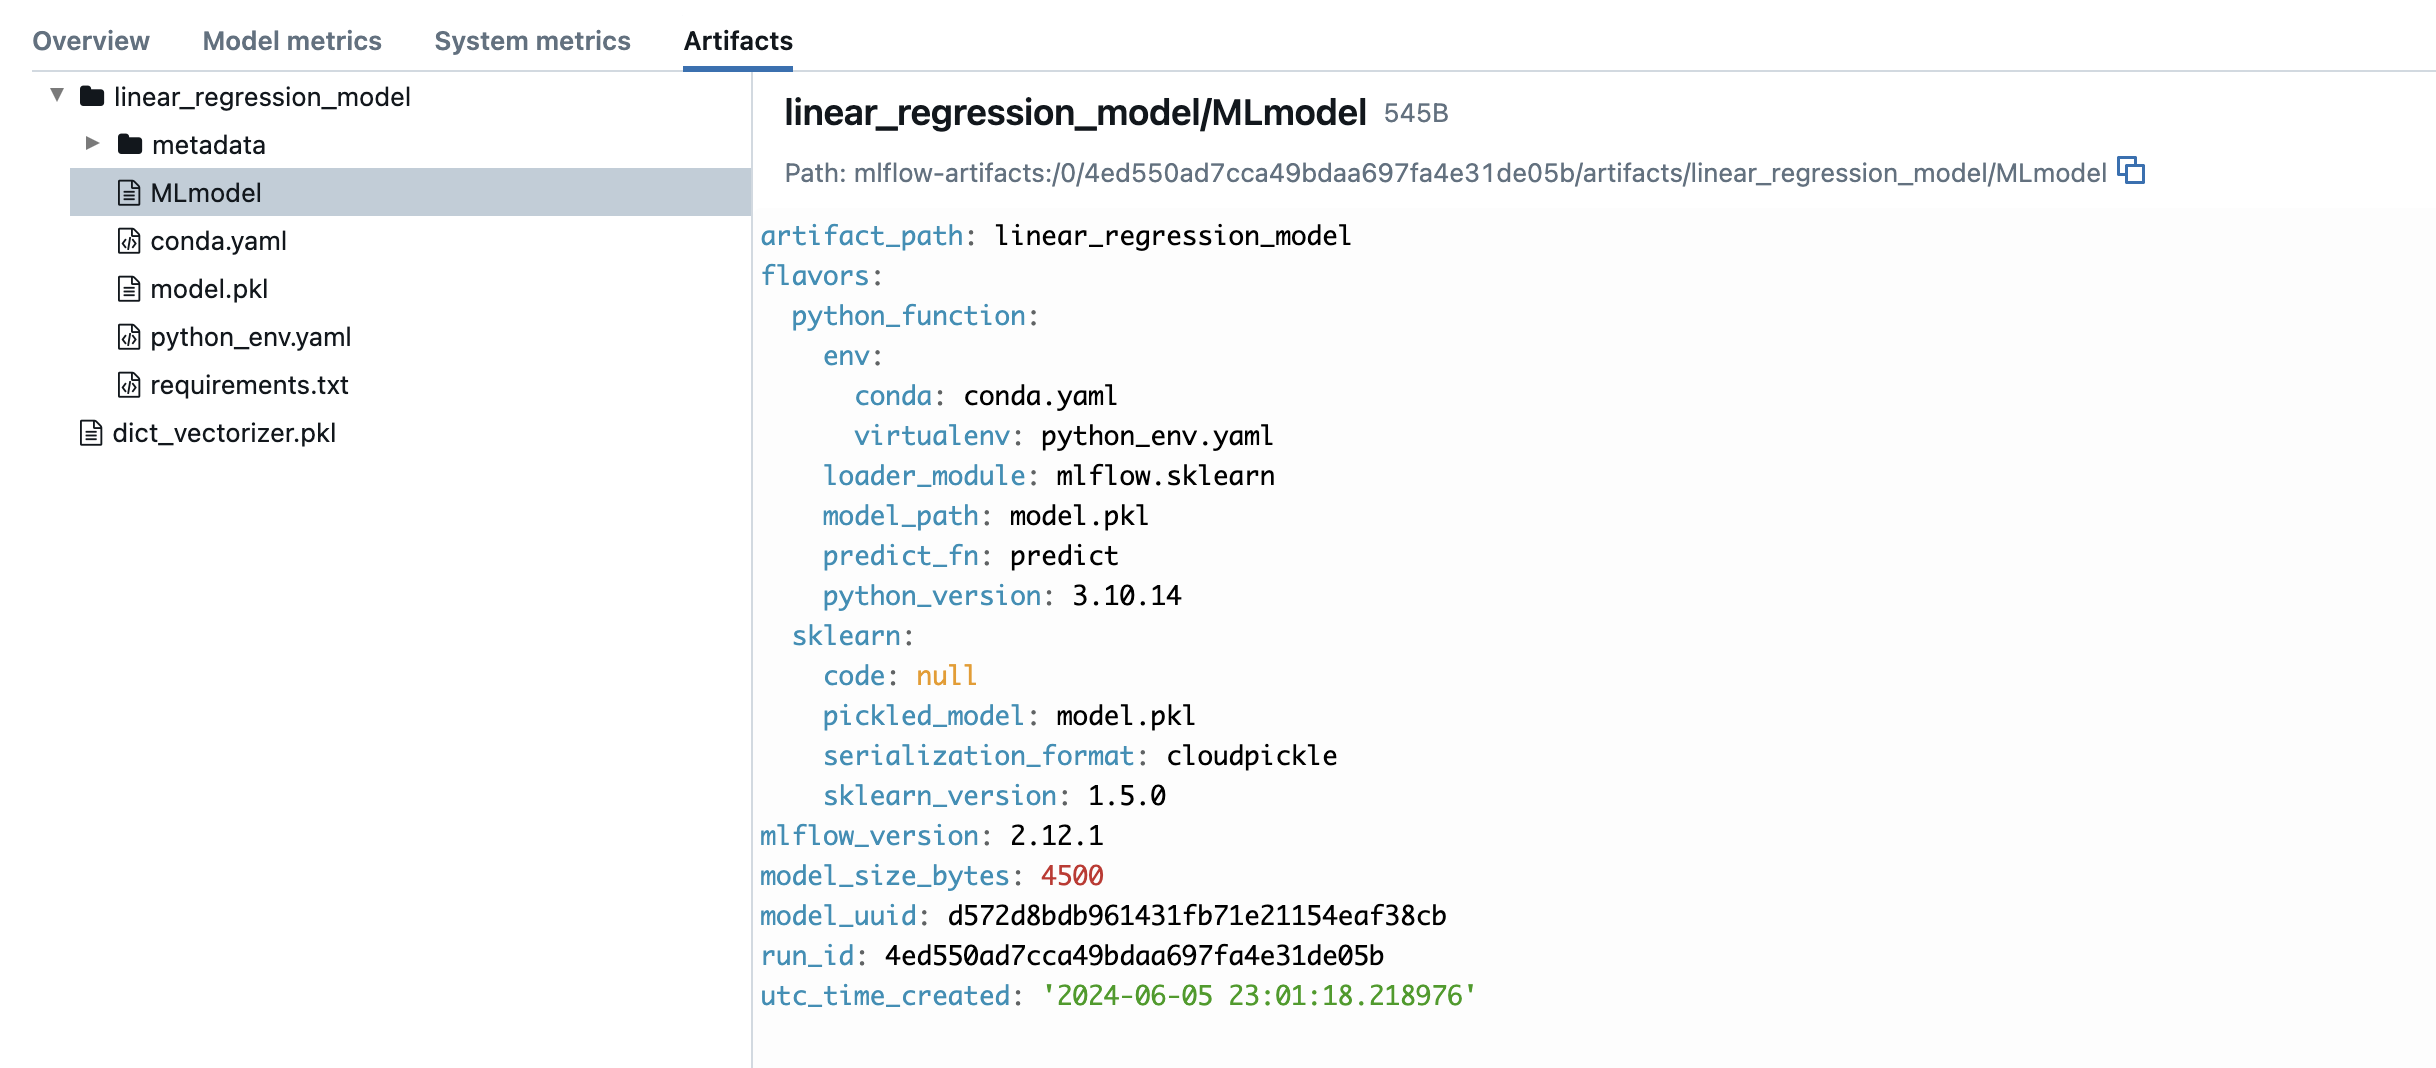

In [6]:
Image('img/q6.png')